<a href="https://colab.research.google.com/github/cuaiswarya/Deep-Learning/blob/main/DL_for_Object_Classification_in_Retail_Stores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
#print(os.listdir("/content/drive/MyDrive/dataset/"))

In [4]:
shelf_images = "/content/drive/MyDrive/dataset/ShelfImages/"
Product_images = "/content/drive/MyDrive/dataset/ProductImagesFromShelves/"
Product_images

'/content/drive/MyDrive/dataset/ProductImagesFromShelves/'

ShelfImages
This folder contains 354 grocery images.

The naming is as follows:

			"C<c>_P<p>_N<n>_S<s>_<i>.JPG"
			where
				<c> := camera id (1: iPhone5S, 2: iPhone4, 3: Sony Cybershot, 4: Nikon Coolpix)
				<p> := planogram id
				<n> := the rank of the top shelf on the image according to the planogram
				<s> := number of shelves on the image
				<i> := copy number

In [5]:
jpg_files = [f for f in os.listdir(f'{shelf_images}') if f.endswith('JPG')]
photos_df = pd.DataFrame([[f, f[:6], f[7:14]] for f in jpg_files], 
                         columns=['file', 'shelf_id', 'planogram_id'])
photos_df.head()

,file,shelf_id,planogram_id
0,C4_P07_N1_S4_1.JPG,C4_P07,N1_S4_1
1,C4_P08_N2_S4_1.JPG,C4_P08,N2_S4_1
2,C4_P06_N1_S4_1.JPG,C4_P06,N1_S4_1
3,C4_P03_N2_S4_1.JPG,C4_P03,N2_S4_1
4,C4_P05_N1_S5_1.JPG,C4_P05,N1_S5_1


ProductImagesFromShelves
This folder contains product images cropped from shelf images. They are divided into 10 product categories plus one negative category where the products not belonging to any of the 10 classes are gathered.

The naming is as follows:

			"<shelf image name>_<x>_<y>_<w>_<h>.png"
			where
			<shelf image name>   := the source image where the image is cropped from
			<x>                  := x-coordinate of the image's top-left corner on the source image
			<y>                  := y-coordinate of the image's top-left corner on the source image
			<w>                  := width of the image on the source image
			<h>                  := height of the image on the source image

In [6]:
products_df = pd.DataFrame(
    [[f[:18], f[:6], f[7:14], float(i), *map(int, f[19:-4].split('_'))] 
     for i in range(11) 
     for f in os.listdir(f'{Product_images}{i}') if f.endswith('png')],
    columns=['file', 'shelf_id', 'planogram_id', 
             'category', 'xmin', 'ymin', 'w', 'h'])

# convert from width height to xmax, ymax
products_df['xmax'] = products_df['xmin'] + products_df['w']
products_df['ymax'] = products_df['ymin'] + products_df['h']
products_df.head()

,file,shelf_id,planogram_id,category,xmin,ymin,w,h,xmax,ymax
0,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,2256,1196,200,304,2456,1500
1,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,1488,1208,196,300,1684,1508
2,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,1704,1676,196,308,1900,1984
3,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,2040,1188,200,304,2240,1492
4,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,1304,1196,196,300,1500,1496


In [7]:
print(products_df.shape)
(products_df.head(5))

(13184, 10)


,file,shelf_id,planogram_id,category,xmin,ymin,w,h,xmax,ymax
0,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,2256,1196,200,304,2456,1500
1,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,1488,1208,196,300,1684,1508
2,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,1704,1676,196,308,1900,1984
3,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,2040,1188,200,304,2240,1492
4,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,1304,1196,196,300,1500,1496


In [8]:
# get distinct shelves
shelves = list(set(photos_df['shelf_id'].values))
print(len(shelves))
print(shelves)

36
['C4_P05', 'C1_P01', 'C1_P09', 'C3_P03', 'C4_P06', 'C3_P02', 'C3_P07', 'C1_P06', 'C4_P08', 'C2_P01', 'C1_P12', 'C2_P06', 'C4_P03', 'C2_P04', 'C1_P03', 'C2_P02', 'C1_P11', 'C1_P08', 'C1_P07', 'C1_P02', 'C4_P04', 'C3_P04', 'C1_P10', 'C1_P04', 'C2_P03', 'C3_P06', 'C2_P09', 'C3_P05', 'C1_P05', 'C4_P02', 'C2_P08', 'C4_P07', 'C2_P07', 'C3_P01', 'C2_P05', 'C4_P01']


In [9]:
# use train_test_split from sklearn
shelves_train, shelves_validation, _, _ = train_test_split(
    shelves, shelves, test_size=0.3, random_state=6)

In [10]:
# mark all records in dataframes with is_train flag

def is_train(shelf_id):
    return shelf_id in shelves_train

photos_df['is_train'] = photos_df['shelf_id'].apply(is_train)
products_df['is_train'] = products_df['shelf_id'].apply(is_train)

In [11]:
photos_df.head(5)

,file,shelf_id,planogram_id,is_train
0,C4_P07_N1_S4_1.JPG,C4_P07,N1_S4_1,True
1,C4_P08_N2_S4_1.JPG,C4_P08,N2_S4_1,True
2,C4_P06_N1_S4_1.JPG,C4_P06,N1_S4_1,True
3,C4_P03_N2_S4_1.JPG,C4_P03,N2_S4_1,True
4,C4_P05_N1_S5_1.JPG,C4_P05,N1_S5_1,False


In [12]:
import pickle

In [13]:
# save to pkl

pickle.dump(photos_df, open('photos.pkl', 'wb'))
my_dict = pickle.load(open('./photos.pkl', 'rb'))
my_dict

,file,shelf_id,planogram_id,is_train
0,C4_P07_N1_S4_1.JPG,C4_P07,N1_S4_1,True
1,C4_P08_N2_S4_1.JPG,C4_P08,N2_S4_1,True
2,C4_P06_N1_S4_1.JPG,C4_P06,N1_S4_1,True
3,C4_P03_N2_S4_1.JPG,C4_P03,N2_S4_1,True
4,C4_P05_N1_S5_1.JPG,C4_P05,N1_S5_1,False
...,...,...,...,...
349,C4_P08_N2_S2_1.JPG,C4_P08,N2_S2_1,True
350,C4_P08_N2_S3_2.JPG,C4_P08,N2_S3_2,True
351,C4_P08_N1_S5_2.JPG,C4_P08,N1_S5_2,True
352,C4_P08_N3_S3_1.JPG,C4_P08,N3_S3_1,True


In [14]:
pickle.dump(products_df, open('products.pkl', 'wb'))
my_dict = pickle.load(open('./products.pkl', 'rb'))
my_dict

,file,shelf_id,planogram_id,category,xmin,ymin,w,h,xmax,ymax,is_train
0,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,2256,1196,200,304,2456,1500,False
1,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,1488,1208,196,300,1684,1508,False
2,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,1704,1676,196,308,1900,1984,False
3,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,2040,1188,200,304,2240,1492,False
4,C4_P05_N2_S4_1.JPG,C4_P05,N2_S4_1,0.0,1304,1196,196,300,1500,1496,False
...,...,...,...,...,...,...,...,...,...,...,...
13179,C4_P07_N3_S3_1.JPG,C4_P07,N3_S3_1,10.0,2488,1392,188,304,2676,1696,True
13180,C4_P07_N3_S3_1.JPG,C4_P07,N3_S3_1,10.0,2144,1360,188,304,2332,1664,True
13181,C4_P07_N3_S3_2.JPG,C4_P07,N3_S3_2,10.0,2456,1300,184,268,2640,1568,True
13182,C4_P07_N3_S3_2.JPG,C4_P07,N3_S3_2,10.0,2136,1296,184,296,2320,1592,True


In [15]:
# function to display shelf photo with rectangled products
def draw_shelf_photo(file):
    file_products_df = products_df[products_df.file == file]
    coordinates = file_products_df[['xmin', 'ymin', 'xmax', 'ymax']].values
    im = cv2.imread(f'{shelf_images}{file}')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)    
    for xmin, ymin, xmax, ymax in coordinates:
        cv2.rectangle(im, (xmin, ymin), (xmax, ymax), (0, 255, 0), 5)
    plt.imshow(im)

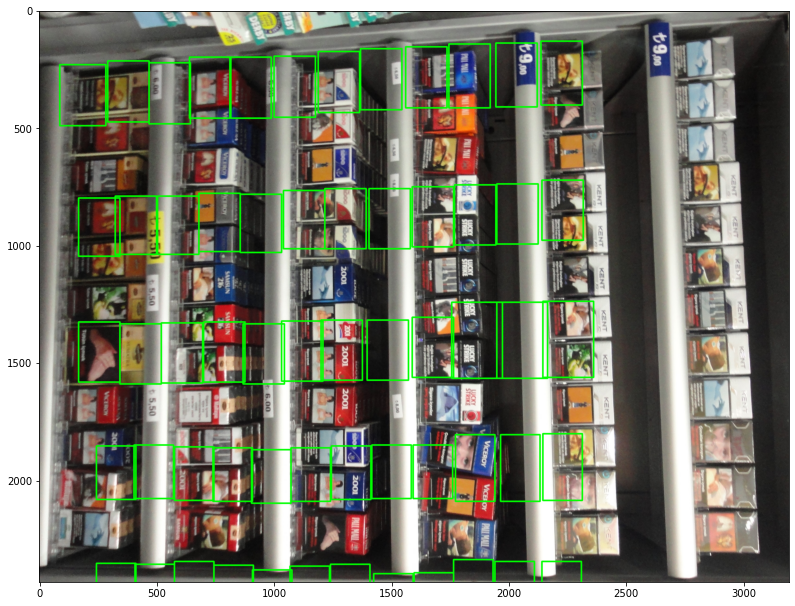

In [16]:
# draw one photo to check our data
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
draw_shelf_photo('C3_P07_N1_S6_1.JPG')

In [17]:
print(photos_df.columns)
print(products_df.columns)

Index(['file', 'shelf_id', 'planogram_id', 'is_train'], dtype='object')
Index(['file', 'shelf_id', 'planogram_id', 'category', 'xmin', 'ymin', 'w',
       'h', 'xmax', 'ymax', 'is_train'],
      dtype='object')


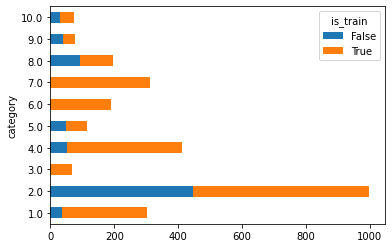

In [18]:
df = products_df[products_df.category != 0].groupby(['category', 'is_train'])['category'].count().unstack('is_train').fillna(0)

df.plot(kind='barh', stacked=True)
plt.show()

Brands Recognition


In [19]:
from IPython.display import Image
Image('/content/drive/MyDrive/dataset/BrandImages.png', width=300)

In [20]:
Image('/content/drive/MyDrive/dataset/BrandImages_recognition.png', width=600)

In [21]:
Image('/content/drive/MyDrive/dataset/BrandImages_recognition_accuracy.png', width=600)

In [22]:
import warnings
warnings.filterwarnings("ignore")

import cv2
import itertools
from sklearn.metrics import confusion_matrix
import pandas as pd,numpy as np,pylab as pl
from skimage.transform import resize
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, Activation
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

In [23]:
data_path = '/content/'


In [24]:
# load data from previous step
photos_df = pd.read_pickle(f'{data_path}photos.pkl')
products_df =  pd.read_pickle(f'{data_path}products.pkl')

In [25]:
# resize pack to fixed size SHAPE_WIDTH*SHAPE_HEIGHT

num_classes = 10
SHAPE_WIDTH = 80
SHAPE_HEIGHT = 120

def resize_pack(pack):
    fx_ratio = SHAPE_WIDTH / pack.shape[1]
    fy_ratio = SHAPE_HEIGHT / pack.shape[0]
    pack = cv2.resize(pack, (0,0), fx=fx_ratio, fy=fy_ratio)
    return pack[0:SHAPE_HEIGHT, 0:SHAPE_WIDTH]

In [27]:
# x - image, y - class, f - is_train flag
x, y, f = [], [], []
for file, is_train in photos_df[['file', 'is_train']].values:
    photo_rects = products_df[products_df.file == file]
    rects_data = photo_rects[['category', 'xmin', 'ymin', 'xmax', 'ymax']]
    im = cv2.imread(f'{shelf_images}{file}')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    for category, xmin, ymin, xmax, ymax in rects_data.values:
        if category == 0:
            continue
        pack = resize_pack(np.array(im[int(ymin):int(ymax), int(xmin):int(xmax)]))
        x.append(pack)
        f.append(is_train)
        y.append(category - 1)

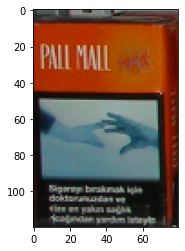

In [28]:
# display one SHAPE_WIDTH x SHAPE_HEIGHT resized pack image, 

plt.imshow(x[60])
plt.show()

In [29]:
# lets split the data into train/validation dataset based on is_train flag
x,y,f = np.array(x), np.array(y), np.array(f)
x_train, x_validation, y_train, y_validation = x[f], x[~f], y[f], y[~f]

# save validation images
x_validation_images = x_validation

x_train.shape, x_validation.shape, y_train.shape, y_validation.shape

((1996, 120, 80, 3), (748, 120, 80, 3), (1996,), (748,))

In [30]:
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils


In [31]:
# convert y_train and y_validation into one hot arrays
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_validation = keras.utils.np_utils.to_categorical(y_validation, num_classes)
y_train.shape, y_validation.shape

((1996, 10), (748, 10))

In [32]:
# normalize x_train and x_validation
x_train, x_validation = x_train.astype('float32'), x_validation.astype('float32')
x_train /= 255
x_validation /= 255

In [33]:
# let's see what do we have
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_validation.shape[0], 'validation samples')

x_train shape: (1996, 120, 80, 3)
y_train shape: (1996, 10)
1996 train samples
748 validation samples


Implement CNN

In [34]:
from __future__ import print_function

import keras
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.models import Model
from keras.regularizers import l2

In [35]:
#Schedule learning rate
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [36]:
#ResNet v1
# Deep Residual Learning for Image Recognition
#ResNet v2
# Identity Mappings in Deep Residual Networks

def get_resnet_model(version, input_shape, depth, num_classes):
    if version == 1:
        return resnet_v1(input_shape, depth, num_classes)
    else:
        return resnet_v2(input_shape, depth, num_classes)

In [37]:

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [38]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    inputs = Input(shape=input_shape)
    #inputs = Input(shape=x_train.shape[1:])
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model   

In [39]:

def resnet_v2(input_shape, depth, num_classes=10):

    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2  # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [44]:
n = 3
version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
model_type = 'ResNet%dv%d' % (depth, version)

model = resnet_v1(input_shape=x_train.shape[1:], depth=depth, num_classes=num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])

Learning rate:  0.001


In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 80, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 120, 80, 16)  448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 80, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [45]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
#test_datagen = ImageDataGenerator(rescale=1./255)
datagen.fit(x_train)


In [46]:
# let's run training process, 20 epochs is enough
batch_size = 50
epochs = 20
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_validation, y_validation),
                    epochs=epochs, verbose=1, workers=4, 
                    callbacks=[LearningRateScheduler(lr_schedule)])

Learning rate:  0.001
Epoch 1/20
40/40 [==============================] - 272s 7s/step - loss: 1.3872 - accuracy: 0.6338 - val_loss: 4.2905 - val_accuracy: 0.0963 - lr: 0.0010
Learning rate:  0.001
Epoch 2/20
40/40 [==============================] - 257s 6s/step - loss: 0.5550 - accuracy: 0.8722 - val_loss: 2.4823 - val_accuracy: 0.3168 - lr: 0.0010
Learning rate:  0.001
Epoch 3/20
40/40 [==============================] - 252s 6s/step - loss: 0.4402 - accuracy: 0.9173 - val_loss: 2.7343 - val_accuracy: 0.3610 - lr: 0.0010
Learning rate:  0.001
Epoch 4/20
40/40 [==============================] - 254s 6s/step - loss: 0.3895 - accuracy: 0.9329 - val_loss: 1.6302 - val_accuracy: 0.5856 - lr: 0.0010
Learning rate:  0.001
Epoch 5/20
40/40 [==============================] - 255s 6s/step - loss: 0.3724 - accuracy: 0.9329 - val_loss: 0.6647 - val_accuracy: 0.8449 - lr: 0.0010
Learning rate:  0.001
Epoch 6/20
40/40 [==============================] - 253s 6s/step - loss: 0.3084 - accuracy: 0.9534